In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Dataset imports:
from data.dataset_alt import *

# Torch imports:
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms as T
from torch.utils.data import Subset, DataLoader, random_split

# Model imports:
from model_alt import *

# Train and evaluation imports:
from train import train
from evaluate import evaluate

# Custom Transforms imports:
from custom_transforms import *

# Plotting imports:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# General imports:
import os
import json
import math
import random

# SKLearn imports:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

# Other imports:
from tqdm import tqdm

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

### Defining the device

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'); device

device(type='cuda', index=0)

In [5]:
torch.backends.cudnn.benchmark = True

# Data preprocessing:

### Getting the mean and standard deviation of the dataset in order to apply normalization on the data:

In [6]:
# Getting the path to the .txt file that contains the mean and std:
DATA_STATS_FILE_NAME = "dataset_stats.txt"
STATS_FILE_PATH = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'data', DATA_STATS_FILE_NAME)

# Reading the statistics file:
stats_dict = None
with open(STATS_FILE_PATH, 'r') as stats_file:
    stats_dict = json.loads(stats_file.read())
    
mean, std = stats_dict['mean'], stats_dict['std']

print(f'Dataset mean: \t\t\t{mean}\nDataset standard deviation: \t{std}')

Dataset mean: 			[0.4944856143767711, 0.4950292797617727, 0.4954058302766022]
Dataset standard deviation: 	[0.28984177278042145, 0.28989603043370027, 0.28941759149050483]


### Creating the preprocessing operations that the images will undergo:

In [7]:
# This Compose includes the following:
#     1) Transforms the images to tensors.
#     2) Normalized the dataset.
#     3) Sharpens the images.

# Creating the sharpness transform:
sharpen = Sharpen(sharpness_factor=2.0)

# Defining the new image dimension:
image_dim = (270, 360)

image_preprocessing = T.Compose([
                            T.ToTensor(),
                            T.transforms.Normalize(mean, std),
                            T.Resize(image_dim),
                            sharpen])

# Defining the dataset:

In [8]:
# Creating the dataset instance:
test_dataset = SkinDataset(transforms=image_preprocessing)

### The dataset class distribution:

In [9]:
data_dist = test_dataset.get_data_distribution()
data_dist

{'akiec': 327,
 'bcc': 514,
 'bkl': 1099,
 'df': 115,
 'mel': 1113,
 'nv': 6705,
 'vasc': 142}

### Plotting the data distribution:

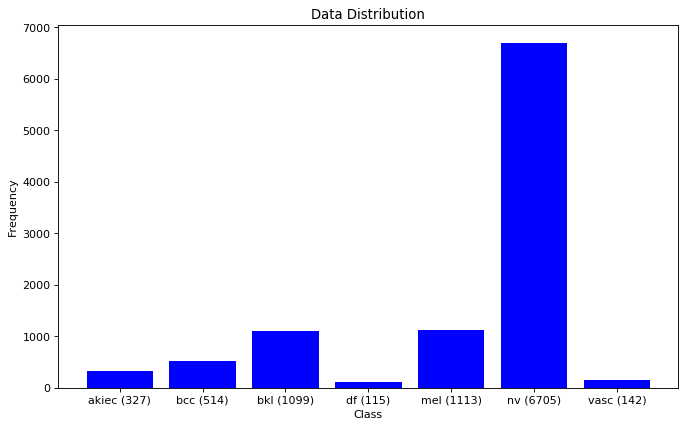

In [10]:
figure(figsize=(10, 6), dpi=80)
plt.title('Data Distribution')

y = list(data_dist.values())
x = [f'{label} ({count})' for label, count in zip(data_dist.keys(), data_dist.values())]

plt.xlabel("Class")
plt.ylabel("Frequency")
plt.bar(x, y, color='b')

plt.show()

# Overfitting Experiment:

### Creating a subset for training:

In [11]:
SUBSET_SIZE = 100
selected_class = 2
sample_array_1 = test_dataset.get_class_indecies(selected_class)

selected_class = 4
sample_array_2 = test_dataset.get_class_indecies(selected_class)

selected_class = 0
sample_array_3 = test_dataset.get_class_indecies(selected_class)

sample_array = sample_array_1 + sample_array_2 + sample_array_3

subset_indicies = np.random.choice(sample_array, SUBSET_SIZE, replace=False)
train_subset = Subset(test_dataset, subset_indicies)

In [12]:
subset_loader = DataLoader(train_subset, shuffle=True, batch_size=32, num_workers=8)

### Creating the model:

In [13]:
model_overfit = Model(num_classes=7, image_dim=image_dim, dropout_prob=[0,0,0])

### The hyperparameters, the loss function and the optimizer:

In [14]:
learning_rate = 6e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_overfit.parameters(), lr=learning_rate)

In [15]:
epochs = 25

### Overfitting the model:

In [16]:
total_loss, epoch_durations, accuracies_train, accuracies_validation = train(model=model_overfit,
                                                                            train_loader=subset_loader,
                                                                            validation_loader=subset_loader,
                                                                            criterion=criterion,
                                                                            optimizer=optimizer,
                                                                            epochs=epochs,
                                                                            verbose=True)

  0%|          | 0/25 [00:00<?, ?it/s]

Evaluating epoch...


  4%|▍         | 1/25 [00:25<10:14, 25.62s/it]

Epoch: 0 | Train_acc: 23.00% | Val_acc: 23.00% | Loss: 11.42 | Runtime: 25.62 seconds
Evaluating epoch...


  8%|▊         | 2/25 [00:48<09:05, 23.72s/it]

Epoch: 1 | Train_acc: 48.00% | Val_acc: 48.00% | Loss: 17.89 | Runtime: 22.39 seconds
Evaluating epoch...


 12%|█▏        | 3/25 [01:09<08:22, 22.84s/it]

Epoch: 2 | Train_acc: 55.00% | Val_acc: 55.00% | Loss: 10.58 | Runtime: 21.80 seconds
Evaluating epoch...


 16%|█▌        | 4/25 [01:31<07:50, 22.42s/it]

Epoch: 3 | Train_acc: 51.00% | Val_acc: 51.00% | Loss: 2.69 | Runtime: 21.78 seconds
Evaluating epoch...


 20%|██        | 5/25 [01:53<07:23, 22.20s/it]

Epoch: 4 | Train_acc: 67.00% | Val_acc: 67.00% | Loss: 3.15 | Runtime: 21.80 seconds
Evaluating epoch...


 24%|██▍       | 6/25 [02:15<06:59, 22.06s/it]

Epoch: 5 | Train_acc: 67.00% | Val_acc: 67.00% | Loss: 3.79 | Runtime: 21.78 seconds
Evaluating epoch...


 28%|██▊       | 7/25 [02:36<06:35, 21.97s/it]

Epoch: 6 | Train_acc: 73.00% | Val_acc: 73.00% | Loss: 3.04 | Runtime: 21.79 seconds
Evaluating epoch...


 32%|███▏      | 8/25 [02:58<06:13, 21.97s/it]

Epoch: 7 | Train_acc: 74.00% | Val_acc: 74.00% | Loss: 2.99 | Runtime: 21.98 seconds
Evaluating epoch...


 36%|███▌      | 9/25 [03:20<05:50, 21.93s/it]

Epoch: 8 | Train_acc: 78.00% | Val_acc: 78.00% | Loss: 2.33 | Runtime: 21.84 seconds
Evaluating epoch...


 40%|████      | 10/25 [03:42<05:28, 21.88s/it]

Epoch: 9 | Train_acc: 80.00% | Val_acc: 80.00% | Loss: 1.98 | Runtime: 21.78 seconds
Evaluating epoch...


 44%|████▍     | 11/25 [04:04<05:05, 21.79s/it]

Epoch: 10 | Train_acc: 84.00% | Val_acc: 84.00% | Loss: 2.12 | Runtime: 21.58 seconds
Evaluating epoch...


 48%|████▊     | 12/25 [04:25<04:42, 21.74s/it]

Epoch: 11 | Train_acc: 83.00% | Val_acc: 83.00% | Loss: 1.63 | Runtime: 21.61 seconds
Evaluating epoch...


 52%|█████▏    | 13/25 [04:47<04:21, 21.75s/it]

Epoch: 12 | Train_acc: 85.00% | Val_acc: 85.00% | Loss: 1.51 | Runtime: 21.78 seconds
Evaluating epoch...


 56%|█████▌    | 14/25 [05:09<04:00, 21.82s/it]

Epoch: 13 | Train_acc: 83.00% | Val_acc: 83.00% | Loss: 1.64 | Runtime: 21.99 seconds
Evaluating epoch...


 60%|██████    | 15/25 [05:31<03:38, 21.81s/it]

Epoch: 14 | Train_acc: 87.00% | Val_acc: 87.00% | Loss: 1.82 | Runtime: 21.78 seconds
Evaluating epoch...


 64%|██████▍   | 16/25 [05:53<03:16, 21.81s/it]

Epoch: 15 | Train_acc: 91.00% | Val_acc: 91.00% | Loss: 2.04 | Runtime: 21.80 seconds
Evaluating epoch...


 68%|██████▊   | 17/25 [06:14<02:54, 21.80s/it]

Epoch: 16 | Train_acc: 93.00% | Val_acc: 93.00% | Loss: 1.07 | Runtime: 21.79 seconds
Evaluating epoch...


 72%|███████▏  | 18/25 [06:36<02:32, 21.74s/it]

Epoch: 17 | Train_acc: 88.00% | Val_acc: 88.00% | Loss: 1.03 | Runtime: 21.59 seconds
Evaluating epoch...


 76%|███████▌  | 19/25 [06:58<02:10, 21.75s/it]

Epoch: 18 | Train_acc: 90.00% | Val_acc: 90.00% | Loss: 1.05 | Runtime: 21.79 seconds
Evaluating epoch...


 80%|████████  | 20/25 [07:20<01:48, 21.77s/it]

Epoch: 19 | Train_acc: 96.00% | Val_acc: 96.00% | Loss: 0.72 | Runtime: 21.81 seconds
Evaluating epoch...


 84%|████████▍ | 21/25 [07:41<01:26, 21.71s/it]

Epoch: 20 | Train_acc: 98.00% | Val_acc: 98.00% | Loss: 0.65 | Runtime: 21.58 seconds
Evaluating epoch...


 88%|████████▊ | 22/25 [08:02<01:04, 21.50s/it]

Epoch: 21 | Train_acc: 99.00% | Val_acc: 99.00% | Loss: 0.52 | Runtime: 21.01 seconds
Evaluating epoch...


 92%|█████████▏| 23/25 [08:23<00:42, 21.40s/it]

Epoch: 22 | Train_acc: 98.00% | Val_acc: 98.00% | Loss: 0.41 | Runtime: 21.15 seconds
Evaluating epoch...


 96%|█████████▌| 24/25 [08:45<00:21, 21.34s/it]

Epoch: 23 | Train_acc: 98.00% | Val_acc: 98.00% | Loss: 0.53 | Runtime: 21.20 seconds
Evaluating epoch...


100%|██████████| 25/25 [09:07<00:00, 21.89s/it]

Epoch: 24 | Train_acc: 100.00% | Val_acc: 100.00% | Loss: 0.38 | Runtime: 22.23 seconds


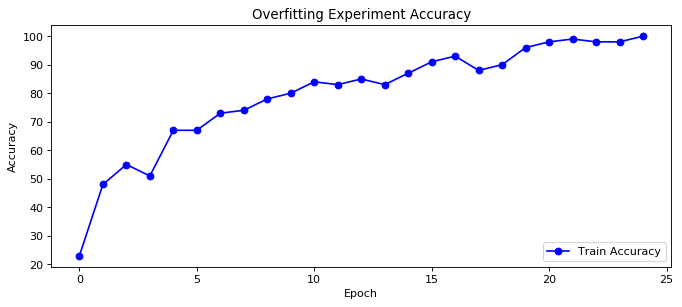

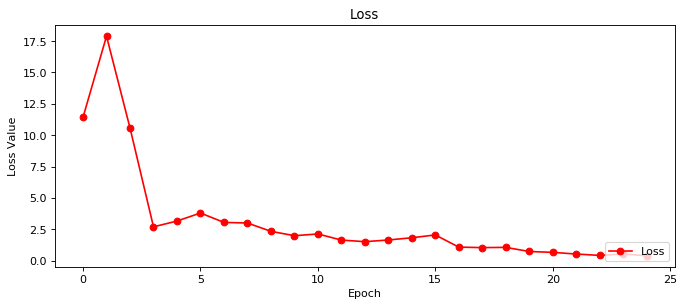

In [17]:
# --- Accuracy: ------------------------------------------------

figure(figsize=(10, 4), dpi=80)
plt.title('Overfitting Experiment Accuracy')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(accuracies_train, 'bo-')
plt.legend(["Train Accuracy"], loc ="lower right")
plt.show()

# --- Loss: ----------------------------------------------------

figure(figsize=(10, 4), dpi=80)

plt.title('Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.plot(total_loss, 'ro-')
plt.legend(["Loss"], loc ="lower right")
plt.show()

# =============================================================

# Setting up the actual model:

### Defining the Dataset object:

In [8]:
dataset = SkinDataset()

### Splitting the dataset into train, validation, and test sets:

In [54]:
# Defining the proportions of how the dataset will be split:
train_proportion = 0.8
validation_proportion = 0.1
test_proportion = 0.1

# Defining the sizes of the splits:

# 1) The train set size:
train_size = math.ceil(train_proportion * len(dataset))

# 2) The validation set size:
validation_size = math.ceil(validation_proportion * len(dataset))

# 3) The test set size:
test_size = math.floor(test_proportion * len(dataset))

# Defining the indecies of the train, validation and test sets:
all_indecies = np.random.choice(list(range(len(dataset))), (10, len(dataset) // 10), replace=False)

train_set_ind = np.random.choice(list(range(all_indecies.shape[0])), int(train_proportion * 10), replace=False)
val_set_ind = np.random.choice(list(range(all_indecies.shape[0])), int(validation_proportion * 10), replace=False)
test_set_ind = np.random.choice(list(range(all_indecies.shape[0])), int(test_proportion * 10), replace=False)

train_set_ind = np.append([], all_indecies[train_set_ind]).astype(np.int)
val_set_ind = np.append([], all_indecies[val_set_ind]).astype(np.int)
test_set_ind = np.append([], all_indecies[test_set_ind]).astype(np.int)

# # Defining the train, validation, and test sets:
train_set = SkinDataset(indecies=train_set_ind)
validation_set = SkinDataset(transforms=image_preprocessing, indecies=val_set_ind)
test_set = SkinDataset(transforms=image_preprocessing, indecies=test_set_ind)

### Saving the test set so it can be used again for evaluation:

In [53]:
# Defining the path where the test indecies will be saved:
save_path = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'data', 'test_split_indecies.txt')

with open(save_path, 'w') as file:
    test_dict = {'test_indecies' : str(list(test_set_ind))}
    json_dump = json.dumps(test_dict)
    file.write(json_dump)

### Plotting the train data distribution before augmentation

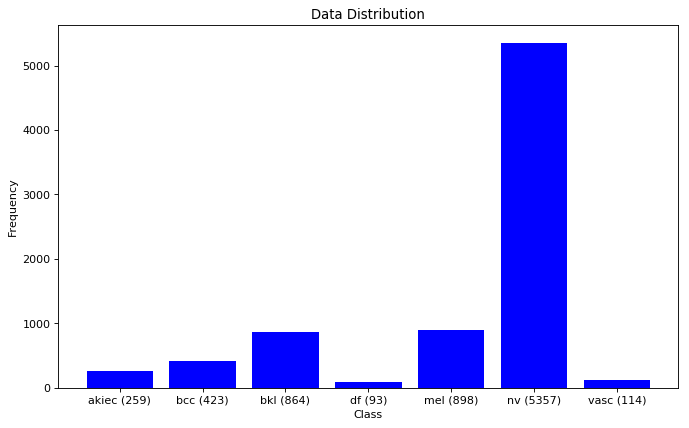

In [10]:
figure(figsize=(10, 6), dpi=80)
plt.title('Data Distribution')


data_dist = train_set.get_data_distribution()
y = list(data_dist.values())
x = [f'{label} ({count})' for label, count in zip(data_dist.keys(), data_dist.values())]

plt.xlabel("Class")
plt.ylabel("Frequency")
plt.bar(x, y, color='b')

plt.show()

# Visualizing the preprocessed and the original data:

In [11]:
train_original = SkinDataset(indecies=train_set_ind)
train_preprocessed = SkinDataset(transforms=image_preprocessing, indecies=train_set_ind)

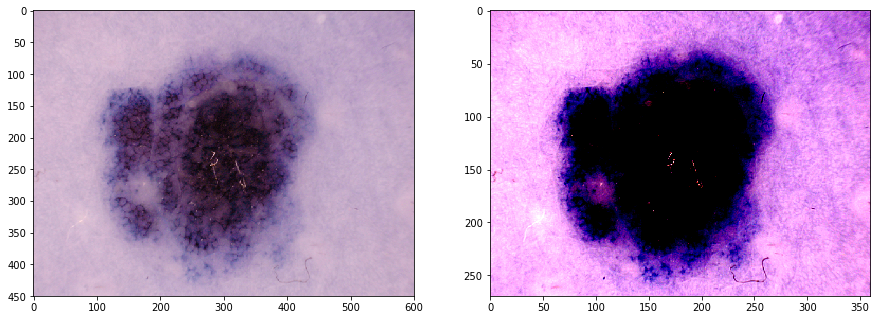

In [12]:
fig, axarr = plt.subplots(1,2)

fig.set_figheight(15)
fig.set_figwidth(15)

index = random.randint(0, len(train_original))

# Retrieving the images:
original_image = train_original[index][0]
preprocessed_image = train_preprocessed[index][0]

# Converting the images to numpy arrays so they can be plotted by matplotlib:
original_image = np.transpose(original_image.cpu().detach().numpy(), (1, 2, 0))
preprocessed_image = np.transpose(preprocessed_image.cpu().detach().numpy(), (1, 2, 0))

axarr[0].imshow(original_image)
axarr[1].imshow(preprocessed_image)

# Augmenting the training data:

### Finding the number of data to be augmented for each class:

In [13]:
augmentation_amount = train_set.find_balancing_aug_amount()
# print(f'Number of data points to be augmented: {sum(augmentation_amount)}')
augmentation_amount

{'akiec': 5098,
 'bcc': 4934,
 'bkl': 4493,
 'df': 5264,
 'mel': 4459,
 'nv': 0,
 'vasc': 5243}

### Creating a new dataset object with augmeted images:

In [14]:
train_set = SkinDataset(transforms=image_preprocessing, indecies=train_set_ind,
                        augment=True, aug_amount=augmentation_amount)

### Showing the new data distribution:

In [15]:
data_dist = train_set.get_data_distribution()
data_dist

{'akiec': 5357,
 'bcc': 5357,
 'bkl': 5357,
 'df': 5357,
 'mel': 5357,
 'nv': 5357,
 'vasc': 5357}

### The size of the dataset after augmetation:

In [16]:
len(train_set)

37499

# Plotting the data distribution after the augmentation:

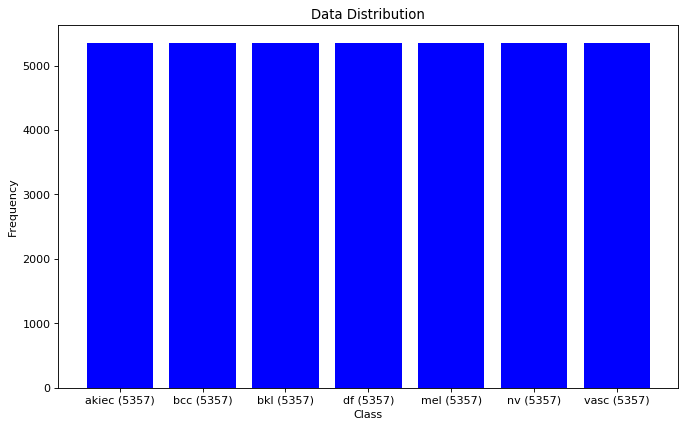

In [17]:
figure(figsize=(10, 6), dpi=80)
plt.title('Data Distribution')

y = list(data_dist.values())
x = [f'{label} ({count})' for label, count in zip(data_dist.keys(), data_dist.values())]

plt.xlabel("Class")
plt.ylabel("Frequency")
plt.bar(x, y, color='b')

plt.show()

# Visualizing the a random subset of the train images after augmentation:

### Getting the sample:

In [18]:
sample_size = 16
index_subsample = np.random.choice(train_set_ind, sample_size)

### Plotting the images:

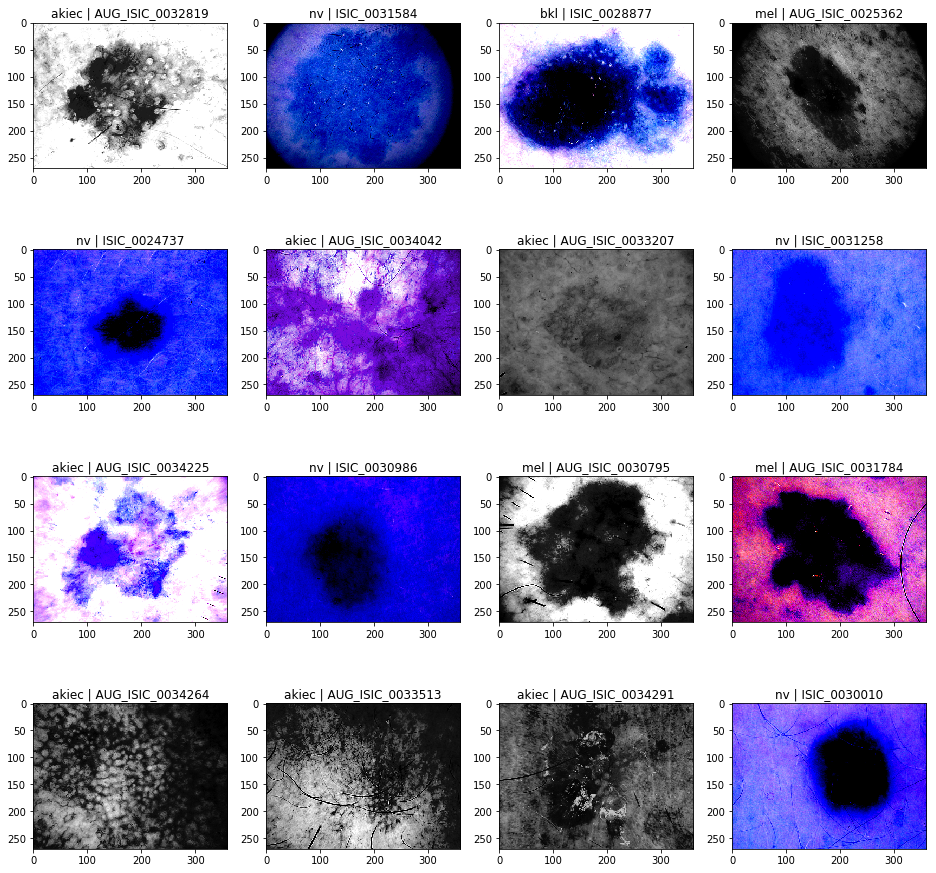

In [19]:
fig, axarr = plt.subplots(4, 4)

fig_size = 16

fig.set_figheight(fig_size)
fig.set_figwidth(fig_size)

for ax, ind in zip(axarr.flatten(), index_subsample):
    # Getting the image:
    image = train_set[ind][0]
    # Converting the image to numpy and applying transpose on its
    # dimension so it can be plotted by matplotlib:
    image = np.transpose(image.cpu().detach().numpy(), (1, 2, 0))
    # Getting the image label and id:
    label = train_set[ind][2]
    im_id = train_set[ind][3]
    title = f'{label} | {im_id}'
    
    ax.set_title(title)
    ax.imshow(image)

### Creating the DataLoader objects:

In [49]:
train_batch_size, validation_batch_size, test_batch_size = 8, 8, 8

# Setting the num_workers to the number of cores on this machine.
num_workers = 8

train_loader = DataLoader(train_set, shuffle=True, batch_size=train_batch_size, num_workers=num_workers, pin_memory=True)
validation_loader = DataLoader(validation_set, shuffle=True, batch_size=validation_batch_size, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=False, batch_size=test_batch_size, num_workers=num_workers, pin_memory=True)

### Creating the model:

In [21]:
dropout_prob = [0.5, 0.5, 0.5]

In [22]:
model = Model(dropout_prob=dropout_prob, num_classes=dataset.num_classes, image_dim=image_dim)

### Defining the optimizer, criterion, and hyperparameters:

In [23]:
learning_rate = 6e-4
weight_decay = 5e-7

# --- Defining the optimizer: ---------------------------------------------------------
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Defining the learning rate schedular:
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=17, gamma=0.1)
scheduler = None
 
# --- Defining the loss function: -----------------------------------------------------
criterion = nn.CrossEntropyLoss()

### Defining the number of epochs:

In [24]:
epochs = 10

# Training the model

In [25]:
total_loss, epoch_durations, accuracies_train, accuracies_validation = train(model=model,
                                                                            train_loader=train_loader,
                                                                            validation_loader=validation_loader,
                                                                            criterion=criterion,
                                                                            optimizer=optimizer,
                                                                            scheduler=scheduler,
                                                                            epochs=epochs,
                                                                            verbose=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating epoch...


 10%|█         | 1/10 [07:29<1:07:24, 449.38s/it]

Epoch: 0 | Train_acc: 32.23% | Val_acc: 20.18% | Loss: 11153.14 | Runtime: 449.38 seconds
Evaluating epoch...


 20%|██        | 2/10 [14:40<58:28, 438.59s/it]  

Epoch: 1 | Train_acc: 70.94% | Val_acc: 74.73% | Loss: 5443.09 | Runtime: 431.03 seconds
Evaluating epoch...


 30%|███       | 3/10 [21:47<50:34, 433.51s/it]

Epoch: 2 | Train_acc: 88.17% | Val_acc: 82.52% | Loss: 2645.17 | Runtime: 427.46 seconds
Evaluating epoch...


 40%|████      | 4/10 [28:35<42:20, 423.42s/it]

Epoch: 3 | Train_acc: 92.77% | Val_acc: 91.01% | Loss: 1468.37 | Runtime: 407.96 seconds
Evaluating epoch...


 50%|█████     | 5/10 [35:26<34:53, 418.68s/it]

Epoch: 4 | Train_acc: 94.25% | Val_acc: 92.41% | Loss: 949.16 | Runtime: 410.26 seconds
Evaluating epoch...


 60%|██████    | 6/10 [42:13<27:40, 415.00s/it]

Epoch: 5 | Train_acc: 96.42% | Val_acc: 94.91% | Loss: 732.75 | Runtime: 407.88 seconds
Evaluating epoch...


 70%|███████   | 7/10 [48:58<20:34, 411.62s/it]

Epoch: 6 | Train_acc: 96.40% | Val_acc: 94.21% | Loss: 609.86 | Runtime: 404.66 seconds
Evaluating epoch...


 80%|████████  | 8/10 [55:43<13:39, 409.59s/it]

Epoch: 7 | Train_acc: 98.08% | Val_acc: 97.50% | Loss: 510.28 | Runtime: 405.25 seconds
Evaluating epoch...


 90%|█████████ | 9/10 [1:02:35<06:50, 410.32s/it]

Epoch: 8 | Train_acc: 97.27% | Val_acc: 94.51% | Loss: 440.96 | Runtime: 411.91 seconds
Evaluating epoch...


100%|██████████| 10/10 [1:09:20<00:00, 416.08s/it]

Epoch: 9 | Train_acc: 97.39% | Val_acc: 97.00% | Loss: 370.77 | Runtime: 405.03 seconds


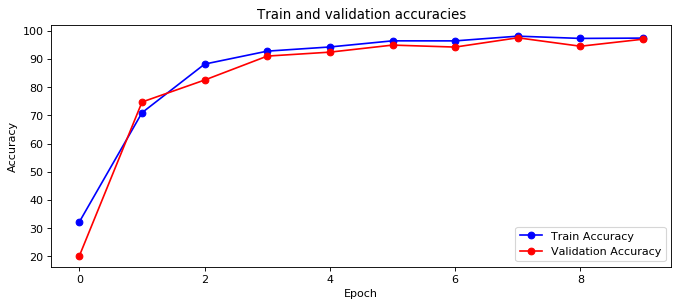

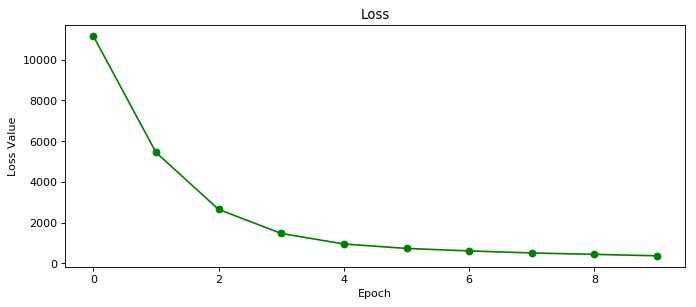

In [26]:
figure(figsize=(10, 4), dpi=80)
plt.title('Train and validation accuracies')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(accuracies_train, 'bo-')
plt.plot(accuracies_validation, 'ro-')

plt.legend(["Train Accuracy", "Validation Accuracy"], loc ="lower right")
plt.show()


figure(figsize=(10, 4), dpi=80)
plt.title('Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.plot(total_loss, 'go-')
plt.show()

# Evaluating the model with the test set:

In [50]:
test_accuracy = evaluate(model=model, data_loader=test_loader, device=device)

In [51]:
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 95.70%


# Class Accuracies

In [52]:
nb_classes = 7
preds_list = []
confusion_mat = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes, _, _) in tqdm(enumerate(test_loader)):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs.float())
        _, preds = torch.max(outputs, 1)
        for item in preds:
            preds_list.append(item.item())
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_mat[t.long(), p.long()] += 1

126it [00:02, 46.56it/s]


In [53]:
classes = np.unique(test_set.labels)

class_accuracies = confusion_mat.diag()/confusion_mat.sum(1)
class_acc_dict = dict(zip(classes, class_accuracies.tolist()))

for cls, accuracy in class_acc_dict.items():
    print(f'{cls}: {100 * accuracy:.2f}%')

akiec: 100.00%
bcc: 98.04%
bkl: 97.96%
df: 100.00%
mel: 87.13%
nv: 96.04%
vasc: 100.00%


In [54]:
ground_truth = test_set.mapped_labels

In [55]:
preds_list = np.array(preds_list)

### Printing the confusion matrix:

In [56]:
conf_mat = confusion_matrix(ground_truth, preds_list)

In [57]:
print(conf_mat)

[[ 36   0   0   0   0   0   0]
 [  0  50   0   0   0   1   0]
 [  0   0  96   0   0   2   0]
 [  0   0   0  13   0   0   0]
 [  0   0   2   1  88  10   0]
 [  1   7   6   1  11 655   1]
 [  0   0   0   0   0   0  20]]


### Testing the model with precision, recall, and f1-score:

In [58]:
print(classification_report(ground_truth, preds_list))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        36
           1       0.88      0.98      0.93        51
           2       0.92      0.98      0.95        98
           3       0.87      1.00      0.93        13
           4       0.89      0.87      0.88       101
           5       0.98      0.96      0.97       682
           6       0.95      1.00      0.98        20

    accuracy                           0.96      1001
   macro avg       0.92      0.97      0.95      1001
weighted avg       0.96      0.96      0.96      1001



# Saving the model:

### Creating the path in which the model will be saved:

In [69]:
path = os.getcwd()
model_name = f'skin_cancer_model'

In [70]:
MODEL_PATH = os.path.join(path, model_name)

### Saving the model:

In [71]:
torch.save(model.state_dict(), MODEL_PATH)